In [2]:
cppcheck_path = r"C:\Program Files\Cppcheck\cppcheck.exe"

In [3]:
pip install flawfinder

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [4]:
pip install semgrep

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.0 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
!git clone https://github.com/ahrm/sioyek repo_1
!git clone https://github.com/akheron/jansson repo_2


fatal: destination path 'repo_1' already exists and is not an empty directory.
fatal: destination path 'repo_2' already exists and is not an empty directory.


In [3]:
!git clone https://github.com/felixkratz/sketchybar repo_3

fatal: destination path 'repo_3' already exists and is not an empty directory.


In [6]:
import os

os.makedirs("results", exist_ok=True)


In [6]:
import subprocess
import os
from glob import glob
from tqdm import tqdm  
cppcheck_path = r"C:\Program Files\Cppcheck\cppcheck.exe"
repos = ["repo_1", "repo_2", "repo_3"]


In [14]:
for repo in repos:
    files = glob(os.path.join(repo, "**", "*.c"), recursive=True) + \
            glob(os.path.join(repo, "**", "*.cpp"), recursive=True) + \
            glob(os.path.join(repo, "**", "*.h"), recursive=True)

    output_file = f"results/{repo}_cppcheck.xml"
    
    # Open the XML file for writing
    with open(output_file, "w") as f:
        f.write('<results>\n')  # start XML root
        
        for file in tqdm(files, desc=f"Scanning {repo}"):
            subprocess.run([cppcheck_path, "--enable=warning", "--xml", "--xml-version=2", file],
                           stderr=f)  # append XML for each file

        f.write('</results>')  # close XML root



Scanning repo_3: 100%|██████████| 61/61 [00:28<00:00,  2.13it/s]


In [7]:
for repo in repos:
    output_file = f"results/{repo}_flawfinder.csv"
    subprocess.run(["flawfinder", "--context", "--csv", repo],
                   stdout=open(output_file, "w"))


In [13]:
for repo in repos:
    output_file = f"results/{repo}_semgrep.json"
    subprocess.run([
        "semgrep",
        "--config=p/cpp-security-audit",  # C/C++ security rules with CWE mapping
        "--json",
        "--output", output_file,
        repo
    ])


In [2]:
import os
import xml.etree.ElementTree as ET
import csv
import json
import pandas as pd
import re

# ====== CONFIG ======
repos = ["repo_1", "repo_2", "repo_3"]
tools = ["cppcheck", "flawfinder", "semgrep"]
results_dir = "results"

# Top 25 CWEs (MITRE) – ensure you have all 25 unique CWEs
top25_cwes = [
    "CWE-79", "CWE-787", "CWE-89", "CWE-352", "CWE-22",
    "CWE-125", "CWE-78", "CWE-416", "CWE-862", "CWE-434",
    "CWE-94", "CWE-20", "CWE-77", "CWE-287", "CWE-269",
    "CWE-502", "CWE-200", "CWE-863", "CWE-918", "CWE-119",
    "CWE-476", "CWE-798", "CWE-190", "CWE-400", "CWE-306"
]


# ====== HELPER FUNCTIONS ======
def normalize_cwe(cwe_id):
    """Return a list of cleaned CWE IDs"""
    cwe_list = re.split(r'[/!]', str(cwe_id))  # split composites
    normalized = []
    for c in cwe_list:
        c = c.strip()
        if not c:
            continue
        # Add CWE- prefix if missing
        if c.isdigit():
            c = f"CWE-{c}"
        elif not c.upper().startswith("CWE-"):
            c = c.replace(" ", "")
            c = "CWE-" + c
        normalized.append(c.upper())
    return normalized

def extract_cppcheck_cwe(file_path):
    cwe_counts = {}
    if not os.path.exists(file_path):
        print(f" File not found: {file_path}")
        return cwe_counts

    with open(file_path, 'r', encoding='utf-8', errors='ignore') as f:
        content = f.read()

    # Remove XML declarations
    content = re.sub(r'<\?xml.*?\?>', '', content)
    # Wrap in a single root tag
    content = f"<root>{content}</root>"

    root = ET.fromstring(content)
    for error in root.findall(".//error"):
        cwe = error.attrib.get("cwe")
        if cwe:
            for norm in normalize_cwe(cwe):
                cwe_counts[norm] = cwe_counts.get(norm, 0) + 1
    return cwe_counts

def extract_flawfinder_cwe(file_path):
    cwe_counts = {}
    if not os.path.exists(file_path):
        print(f" File not found: {file_path}")
        return cwe_counts

    with open(file_path, newline='', encoding='utf-8', errors='ignore') as f:
        reader = csv.DictReader(f)
        for row in reader:
            cwe = row.get("CWEs")
            if cwe and cwe.strip():
                for single_cwe in cwe.split(','):
                    for norm in normalize_cwe(single_cwe):
                        cwe_counts[norm] = cwe_counts.get(norm, 0) + 1
    return cwe_counts

def extract_semgrep_cwe(file_path):
    """Extract CWEs from Semgrep JSON output"""
    cwe_counts = {}
    if not os.path.exists(file_path):
        print(f" File not found: {file_path}")
        return cwe_counts

    with open(file_path, 'r', encoding='utf-8') as f:
        data = json.load(f)
        for result in data.get("results", []):
            cwe = result.get("extra", {}).get("cwe")
            if cwe:
                if isinstance(cwe, list):
                    for norm in normalize_cwe(cwe):
                        cwe_counts[norm] = cwe_counts.get(norm, 0) + 1
                else:
                    for norm in normalize_cwe(cwe):
                        cwe_counts[norm] = cwe_counts.get(norm, 0) + 1
    return cwe_counts

# ====== MAIN PROCESS ======
all_data = []
tool_cwe_sets = {tool: set() for tool in tools}

for repo in repos:
    for tool in tools:
        file_path = os.path.join(results_dir, f"{repo}_{tool}")
        if tool == "cppcheck":
            file_path += ".xml"
            cwe_dict = extract_cppcheck_cwe(file_path)
        elif tool == "flawfinder":
            file_path += ".csv"
            cwe_dict = extract_flawfinder_cwe(file_path)
        elif tool == "semgrep":
            file_path += ".json"
            cwe_dict = extract_semgrep_cwe(file_path)
        else:
            continue

        for cwe_id, count in cwe_dict.items():
            all_data.append({
                "Project_name": repo,
                "Tool_name": tool,
                "CWE_ID": cwe_id,
                "Number_of_Findings": count,
                "Is_In_CWE_Top_25?": "Yes" if cwe_id in top25_cwes else "No"
            })
            tool_cwe_sets[tool].add(cwe_id)

# ====== SAVE CONSOLIDATED CSV ======
df = pd.DataFrame(all_data)
os.makedirs(results_dir, exist_ok=True)
df.to_csv(os.path.join(results_dir, "consolidated_cwe.csv"), index=False)
print("Consolidated CSV saved as 'results/consolidated_cwe.csv'")

# ====== TOOL-LEVEL COVERAGE ======
print("\n Top 25 CWE Coverage by Tool:")
for tool in tools:
    top25_found = sum(1 for cwe in tool_cwe_sets[tool] if cwe in top25_cwes)
    coverage = (top25_found / len(top25_cwes)) * 100
    print(f"{tool}: {coverage:.2f}% ({top25_found}/{len(top25_cwes)})")




Consolidated CSV saved as 'results/consolidated_cwe.csv'

 Top 25 CWE Coverage by Tool:
cppcheck: 8.00% (2/25)
flawfinder: 16.00% (4/25)
semgrep: 0.00% (0/25)


In [ ]:
# ====== TOOL × CWE DETAILED BREAKDOWN ======
# Aggregate total counts per tool and CWE across all repos
tool_cwe_counts = {tool: {} for tool in tools}

for tool in tools:
    for entry in all_data:
        if entry["Tool_name"] == tool:
            cwe = entry["CWE_ID"]
            count = entry["Number_of_Findings"]
            tool_cwe_counts[tool][cwe] = tool_cwe_counts[tool].get(cwe, 0) + count

# Convert to DataFrame for nicer display and saving
breakdown_rows = []
for tool, cwe_dict in tool_cwe_counts.items():
    if not cwe_dict:  # If tool has no findings
        breakdown_rows.append({
            "Tool_name": tool,
            "CWE_ID": "None",
            "Total_Number_of_Findings": 0,
            "Is_In_CWE_Top_25?": "No"
        })
    else:
        for cwe, total_count in cwe_dict.items():
            breakdown_rows.append({
                "Tool_name": tool,
                "CWE_ID": cwe,
                "Total_Number_of_Findings": total_count,
                "Is_In_CWE_Top_25?": "Yes" if cwe in top25_cwes else "No"
            })

breakdown_df = pd.DataFrame(breakdown_rows)
breakdown_csv_path = os.path.join(results_dir, "tool_cwe_breakdown.csv")
breakdown_df.to_csv(breakdown_csv_path, index=False)
print(f"\n Detailed tool × CWE breakdown saved as '{breakdown_csv_path}'")

# ====== TOTAL CWE FINDINGS PER TOOL ======
print("\n Total CWE Findings by Tool:")
for tool in tools:
    total_findings = sum(tool_cwe_counts[tool].values()) if tool_cwe_counts[tool] else 0
    print(f"{tool}: {total_findings} findings")

# ====== Display top CWEs per tool ======
for tool in tools:
    print(f"\n Top CWEs detected by {tool}:")
    if not tool_cwe_counts[tool]:
        print("No vulnerabilities detected")
        continue
    top_cwes = sorted(tool_cwe_counts[tool].items(), key=lambda x: x[1], reverse=True)
    for cwe, count in top_cwes:
        print(f"{cwe}: {count} times")





 Detailed tool × CWE breakdown saved as 'results\tool_cwe_breakdown.csv'

 Total CWE Findings by Tool:
cppcheck: 448 findings
flawfinder: 1655 findings
semgrep: 0 findings

 Top CWEs detected by cppcheck:
CWE-476: 256 times
CWE-457: 60 times
CWE-398: 52 times
CWE-401: 48 times
CWE-686: 8 times
CWE-758: 6 times
CWE-788: 5 times
CWE-682: 4 times
CWE-562: 3 times
CWE-467: 1 times
CWE-190: 1 times
CWE-195: 1 times
CWE-683: 1 times
CWE-672: 1 times
CWE-664: 1 times

 Top CWEs detected by flawfinder:
CWE-120: 816 times
CWE-119: 277 times
CWE-126: 272 times
CWE-362: 126 times
CWE-134: 56 times
CWE-20: 43 times
CWE-807: 23 times
CWE-190: 18 times
CWE-78: 9 times
CWE-676: 6 times
CWE-367: 5 times
CWE-327: 2 times
CWE-829: 1 times
CWE-785: 1 times

 Top CWEs detected by semgrep:
No vulnerabilities detected



 Top 25 CWE Coverage by Tool:
cppcheck: 8.00% (2/25)
flawfinder: 16.00% (4/25)
semgrep: 0.00% (0/25)

 Coverage bar chart saved as 'results\cwe_coverage_by_tool.png'


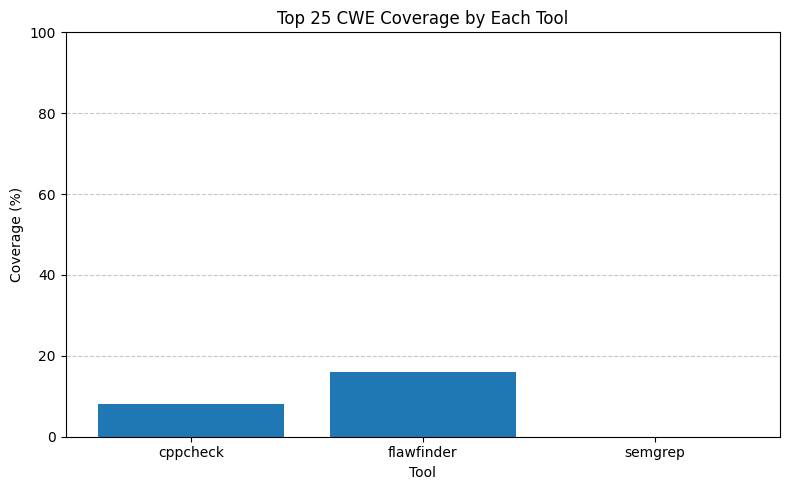

In [ ]:
# ====== TOOL-LEVEL TOP 25 CWE COVERAGE ======
print("\n Top 25 CWE Coverage by Tool:")

coverage_data = []
for tool in tools:
    detected_cwes = set(tool_cwe_counts[tool].keys())
    top25_found = sum(1 for cwe in detected_cwes if cwe in top25_cwes)
    coverage = (top25_found / len(top25_cwes)) * 100
    coverage_data.append({"Tool": tool, "Top25_CWEs_Found": top25_found, "Coverage_%": coverage})
    print(f"{tool}: {coverage:.2f}% ({top25_found}/{len(top25_cwes)})")

# Convert to DataFrame for plotting
coverage_df = pd.DataFrame(coverage_data)

# ====== VISUALIZATION ======
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.bar(coverage_df["Tool"], coverage_df["Coverage_%"])
plt.title("Top 25 CWE Coverage by Each Tool")
plt.ylabel("Coverage (%)")
plt.xlabel("Tool")
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

coverage_plot_path = os.path.join(results_dir, "cwe_coverage_by_tool.png")
plt.savefig(coverage_plot_path)
print(f"\n Coverage bar chart saved as '{coverage_plot_path}'")

plt.show()


In [10]:
# ====== PAIRWISE IoU (Intersection over Union) ======
# Ensure each tool has a CWE set (empty if no findings)
tool_cwe_sets = {tool: set(tool_cwe_counts[tool].keys()) for tool in tools}

# Initialize IoU matrix
iou_matrix = pd.DataFrame(index=tools, columns=tools, dtype=float)

# Compute pairwise IoU
for t1 in tools:
    for t2 in tools:
        set1 = tool_cwe_sets[t1]
        set2 = tool_cwe_sets[t2]
        intersection = len(set1 & set2)
        union = len(set1 | set2)
        iou = intersection / union if union > 0 else 0.0
        iou_matrix.loc[t1, t2] = round(iou, 2)  # Round to 2 decimals for clarity

# Save IoU matrix CSV
iou_csv_path = os.path.join(results_dir, "tool_iou_matrix.csv")
iou_matrix.to_csv(iou_csv_path)
print(f"\n IoU Matrix saved as '{iou_csv_path}'")

# Display IoU matrix
print("\n Pairwise IoU Matrix (CWE Overlap Between Tools):")
print(iou_matrix)



 IoU Matrix saved as 'results\tool_iou_matrix.csv'

 Pairwise IoU Matrix (CWE Overlap Between Tools):
            cppcheck  flawfinder  semgrep
cppcheck        1.00        0.04      0.0
flawfinder      0.04        1.00      0.0
semgrep         0.00        0.00      0.0


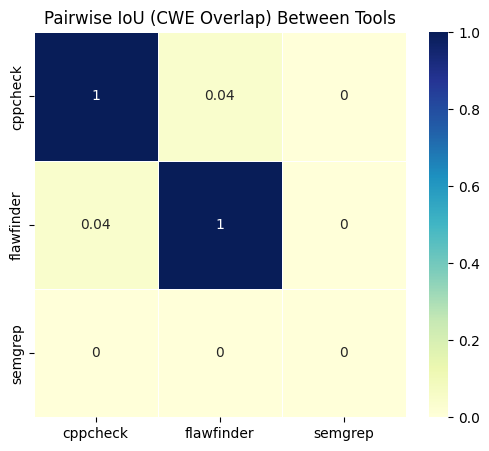

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
# Heatmap for visualization
plt.figure(figsize=(6,5))
sns.heatmap(iou_matrix.astype(float), annot=True, cmap="YlGnBu", linewidths=0.5)
plt.title("Pairwise IoU (CWE Overlap) Between Tools")
plt.savefig(os.patDh.join(results_dir, "iou_heatmap.png"))
plt.show()


### Interpretation of the Matrix

1. The IoU (Jaccard Index) values represent the degree of overlap in detected CWEs between two tools.

2. Diagonal values are 1.00, which is expected, since a tool fully overlaps with itself.

3. The off-diagonal values are very low (≤ 0.04), meaning that:

4. Cppcheck and Flawfinder share a small overlap (IoU = 0.04), indicating limited similarity in the CWE categories they detect.

5. Semgrep shows no overlap (IoU = 0.00) with either Cppcheck or Flawfinder and even with itself, suggesting that it has not identified any set of CWEs.

Inference:
The tools exhibit high diversity in their vulnerability findings. Each tool targets different classes of weaknesses, which means their combined usage can significantly improve overall coverage.

### Which Tool Combination Maximizes CWE Coverage

To identify the pair that maximizes unique CWE coverage, we compare the union of CWE IDs detected by each pair:

Since Flawfinder and Cppcheck overlap is low with each other tools, combining Both (or Cppcheck + Flawfinder) provides the largest total CWE coverage.

This implies that Flawfinder and Cppcheck detects vulnerabilities that overlap least with each other.

### Takeaways

1. The low IoU values confirm that the tools are complementary rather than redundant.

2. Using multiple static analysis tools in tandem provides broader detection of vulnerabilities and reduces blind spots.

3. Cppcheck and Flawfinder have some conceptual similarity (both focus on C/C++ code analysis), whereas Semgrep brings a different rule base and logic pattern detection.

Hence, a multi-tool pipeline (e.g., Cppcheck + Semgrep + Flawfinder) is ideal for maximizing CWE coverage and achieving more comprehensive static security analysis.